# Monthly Readers Interactions #

In [93]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(ggplot2); library(lubridate); library(scales); library(reshape2);
    library(wmf)
})


## Monthly Pageviews ##

Pageviews data comes from wmf.pageview_hourly for spurious IE views from some countries. Corrected data is stored in intermediate hive table mneisler.pageviews_corrected with data stored back to September 2016. 

List of corrections and timespans that they are applied to:

* IEPKIRAF: since May 20, 2018
* IE7PKIRAF: January 1-May 19, 2018
* IE7PKIRAF & iOS mainpage: Sept 2016-Dec 31, 2017


### Update pageviews_corrected table ###

In [ ]:
#Remember to update month to current metrics month and year
metrics_month = '07'
metrics_year = '2019'

In [19]:
#update pageviews_corrected table with new month data.

update_pageviews_query <- "
INSERT INTO TABLE mneisler.pageviews_corrected
PARTITION (year, month, day)
SELECT 
  CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
  SUM(IF(access_method = 'mobile app', view_count, null)) AS apps,
  SUM(IF(access_method = 'desktop', view_count, null)) AS desktop,
  SUM(IF(access_method = 'mobile web', view_count, null)) AS mobileweb,
  SUM(view_count) as total,
  year, month, day
FROM wmf.pageview_hourly
  WHERE (year = '{metrics_year}'AND month = '{metrics_month}')
  AND agent_type='user'
  AND NOT (country_code IN ('PK', 'IR', 'AF') -- https://phabricator.wikimedia.org/T157404#3194046
  AND user_agent_map['browser_family'] = 'IE') -- https://phabricator.wikimedia.org/T193578#4300284
  GROUP BY year, month, day"


In [ ]:
wmf::query_hive(update_pageviews_query)

### All pageviews ###

In [94]:
## Run pageview query and load data
query <- "
SELECT
date, apps, desktop, mobileweb, total
FROM mneisler.pageviews_corrected
WHERE year >= 2017
"

In [95]:
pageviews_all <- wmf::query_hive(query)

In [96]:
pageviews_all$date <- as.Date(pageviews_all$date, format = "%Y-%m-%d")

In [97]:
# Find total pageviews per month with yoy changes
pageviews_all_monthly <- pageviews_all %>%
  mutate(date = floor_date(date, "month")) %>%
  group_by(date) %>%
  summarise(monthly_views = sum(as.numeric(total))) %>%
  arrange(date) %>%
  mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1) *100) %>%
  mutate(type = "pageviews")

tail(pageviews_all_monthly)

date,monthly_views,yoy_percent,type
<date>,<dbl>,<dbl>,<chr>
2019-02-01,14994451563,0.6880624,pageviews
2019-03-01,16323127594,0.5428818,pageviews
2019-04-01,15661204060,1.3725208,pageviews
2019-05-01,16328875602,1.5357259,pageviews
2019-06-01,14840496959,-0.9046639,pageviews
2019-07-01,15377558086,0.1557495,pageviews


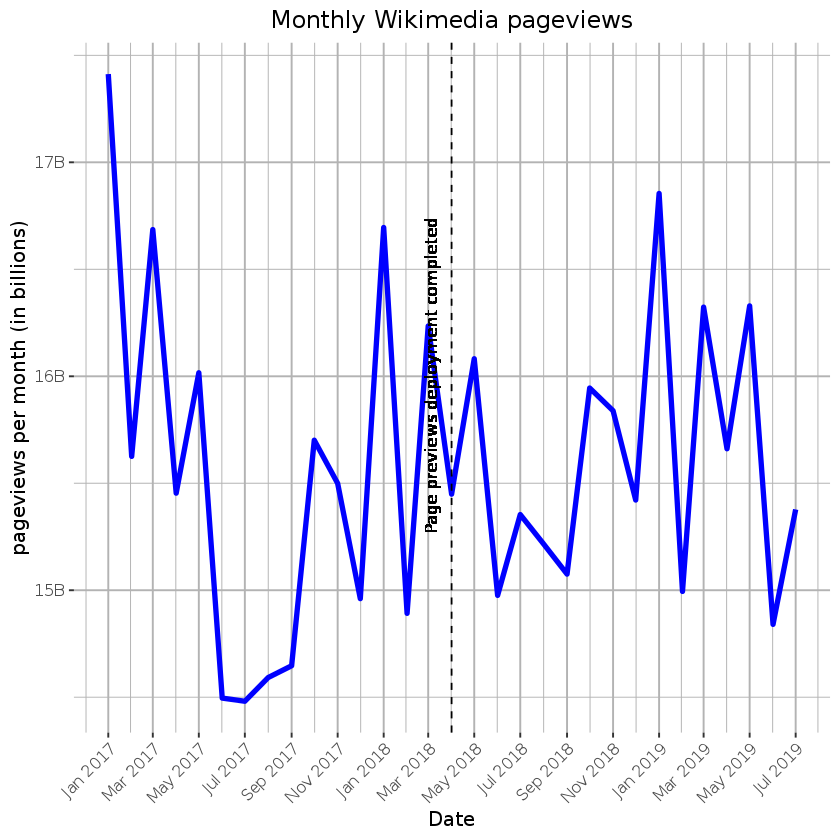

In [98]:
p <- ggplot(pageviews_all_monthly, aes(x=date, y = monthly_views)) +  
  geom_line(color = 'blue', size = 1.5) +
  geom_vline(xintercept = as.numeric(as.Date("2018-04-01")),
             linetype = "dashed", color = "black") +
  geom_text(aes(x=as.Date('2018-04-01'), y=16E9, label="Page previews deployment completed"), size=3.5, vjust = -1.2, angle = 90, color = "black") +
  scale_y_continuous("pageviews per month (in billions)", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "2 months") +
  labs(title = "Monthly Wikimedia pageviews") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"))

ggsave(filename="Monthly pageviews monthly time series.png", plot = p, path = "Figures", units = "in", dpi = 150, height = 6, width = 10, limitsize = FALSE)  
p

### Desktop Pageviews ###

In [99]:
pageviews_desktop <- pageviews_all %>%
  mutate(date = floor_date(date, "month")) %>%
  select(c(1,3))  %>% #select desktop and date column
  group_by(date) %>%
  summarise(monthly_views = sum(as.numeric(desktop))) %>%
  arrange(date) %>%
   mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1) *100) 

tail(pageviews_desktop)

date,monthly_views,yoy_percent
<date>,<dbl>,<dbl>
2019-02-01,6264340878,-9.110229
2019-03-01,6740714008,-10.365101
2019-04-01,6407008283,-9.409152
2019-05-01,6630746673,-8.305277
2019-06-01,5790501161,-11.877252
2019-07-01,5894085058,-10.265117


### Mobile Web Pageviews ###

In [100]:
pageviews_mobileweb <- pageviews_all  %>%
  mutate(date = floor_date(date, "month")) %>%
  select(c(1,4))  %>% #select mobile web and date column
  group_by(date) %>%
  summarise(monthly_views = sum(as.numeric(mobileweb))) %>%
  arrange(date) %>%
 mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1) *100) 

tail(pageviews_mobileweb)

date,monthly_views,yoy_percent
<date>,<dbl>,<dbl>
2019-02-01,8500267968,9.274550
2019-03-01,9330934371,10.112440
2019-04-01,9013609978,10.659948
2019-05-01,9442723863,9.777265
2019-06-01,8804953590,7.821037
2019-07-01,9226141926,8.101955


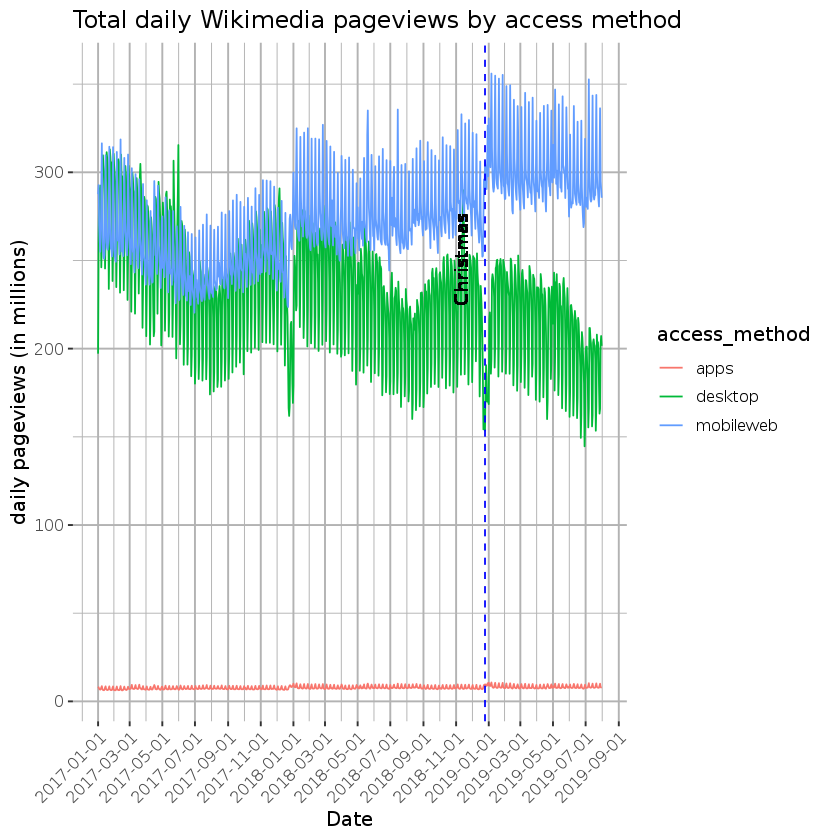

In [101]:
pageviews_byaccess <- pageviews_all %>%
  select(-c(5)) %>% #remove total column as it's not needed for this chart
  melt(id.vars = c("date"), measure.vars = c("apps", "desktop", "mobileweb"),
       variable.name = "access_method", value.name = 'views')

p <- ggplot(pageviews_byaccess, aes(x=date, y = (views/1000000), color = access_method)) +  
  geom_line() +
  geom_vline(xintercept = as.numeric(as.Date("2018-12-25")),
             linetype = "dashed", color = "blue") +
  geom_text(aes(x=as.Date('2018-12-25'), y=250, label="Christmas"), size=4, vjust = -1.2, angle = 90, color = "black") +
  scale_y_continuous("daily pageviews (in millions)") +
  scale_x_date("Date", labels = date_format("%Y-%m-%d"), date_breaks = "2 months") +
  labs(title = "Total daily Wikimedia pageviews by access method") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"))


ggsave(filename="Daily pageviews byaccess method.png", plot = p, path = "Figures", units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

### YOY Chart ###

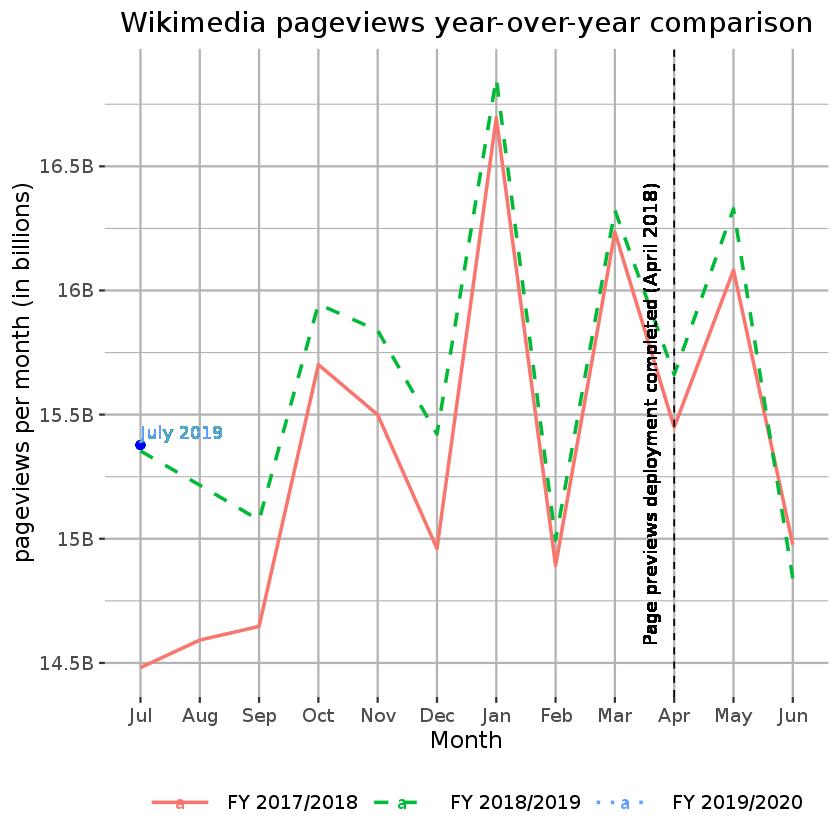

In [123]:
#Show Fiscal year YOY Chart

pageviews_all_monthly_fy2 <- pageviews_all_monthly %>%
  filter(date >= '2017-07-01') %>%
  mutate(fiscal_year = case_when(date >= '2017-07-01' & date < '2018-07-01' ~ 'FY 2017/2018', 
                                 date >= '2018-07-01' & date < '2019-07-01' ~ 'FY 2018/2019',
                                 date >= '2019-07-01' & date < '2020-07-01' ~ 'FY 2019/2020'),
         MonthN =as.factor(format(as.Date(date),"%m")),
         Month = months(as.Date(date), abbreviate=TRUE))


pageviews_all_monthly_fy2$MonthN = factor(pageviews_all_monthly_fy2$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))
  

p <- ggplot(pageviews_all_monthly_fy2, aes(x=MonthN, y = monthly_views, group = fiscal_year, color = fiscal_year, linetype = fiscal_year)) +  
  geom_line(size = 1) +
#add point to show july 19 as it's the first month of the new fiscal year.
  geom_point(x=01, y=15377558086 , size = 2, color = 'blue') +
  geom_text(aes(x =01, y=15400000000, label="July 2019"),hjust=0, vjust=0) +
  geom_vline(xintercept = 10,
             linetype = "dashed", color = "black") +
  geom_text(aes(x=10, y=15.5E9, label="Page previews deployment completed (April 2018)"), size=4, vjust = -1.2, angle = 90, color = "black") +
  scale_y_continuous("pageviews per month (in billions)", labels = polloi::compress) +
  scale_x_discrete(breaks = pageviews_all_monthly_fy$MonthN, labels = pageviews_all_monthly_fy$Month )+
  labs(title = "Wikimedia pageviews year-over-year comparison") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.title = element_blank(),
        legend.position = "bottom",
        panel.grid = element_line("gray70"),
        legend.key.width=unit(1.5,"cm")) +
  xlab("Month") +
  scale_linetype_manual(breaks=c('FY 2017/2018','FY 2018/2019', 'FY 2019/2020'), values=c(1, 2, 3))

ggsave(filename="Pageviews_monthly_yoy2.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p


## Monthly Previews ##

Seen page previews, defined as previews popups that remain visible for at least one second. Data from [wmf.virtaulpageview_hourly](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Virtualpageview_hourly). 

In [76]:
# Collect previews from wmf.virtualpageview_hourly. Page previews was completed in April 2018.

previews_query <- "
SELECT CONCAT(year,'-',LPAD(month,2,'0'),'-',LPAD(day,2,'0')) AS date,
  SUM(view_count) AS previews_seen
  FROM wmf.virtualpageview_hourly 
  WHERE (year = 2018 AND month >=4) OR (year = 2019)
  GROUP BY year, month, day
  ORDER BY date LIMIT 10000;
"

In [77]:
previews_all <- wmf::query_hive(previews_query)

In [78]:
previews_all$date <- as.Date(previews_all$date, format = "%Y-%m-%d")

In [80]:
previews_all_monthly <- previews_all %>%
  mutate(date = floor_date(date, "month"))  %>%
  group_by(date) %>%
  summarise(monthly_views = sum(as.numeric(previews_seen))) %>%
  arrange(date) %>%
mutate(yoy_percent = (monthly_views/lag(monthly_views,12) -1) *100)  %>%
  mutate(type = "previews")

tail(previews_all_monthly)

date,monthly_views,yoy_percent,type
<date>,<dbl>,<dbl>,<chr>
2019-02-01,1738551430,NA,previews
2019-03-01,1867233307,NA,previews
2019-04-01,1759067428,36.667830,previews
2019-05-01,1850432228,-5.835993,previews
2019-06-01,1609282924,-9.359771,previews
2019-07-01,1643555455,-1.309236,previews


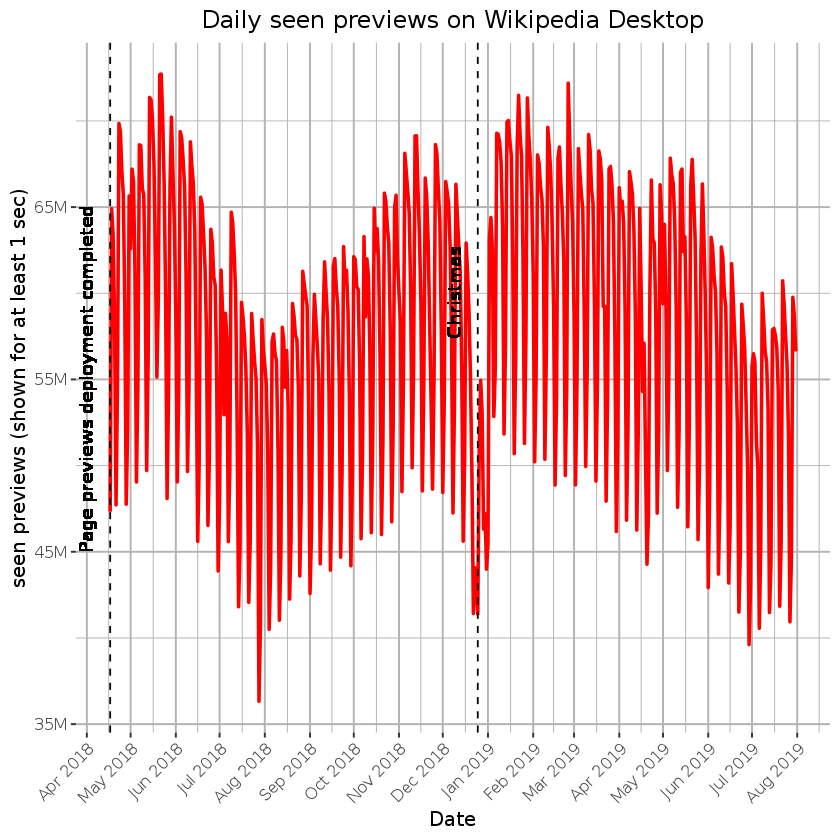

In [81]:
previews_all_daily <- previews_all %>% 
  filter(date >= '2018-04-17')  #Filter out dates that occured before page previews rollout was completed.

p <- ggplot(previews_all_daily, aes(x=date, y = previews_seen)) +  
  geom_line(color = 'red', size = 1) +
  geom_vline(xintercept = as.numeric(as.Date("2018-04-17")),
             linetype = "dashed", color = "black")+
  geom_vline(xintercept = as.numeric(as.Date("2018-12-25")),
             linetype = "dashed", color = "black")+
  geom_text(aes(x=as.Date('2018-12-25'), y=60E6, label="Christmas"), size=4, vjust = -1.2, angle = 90, color = "black") +
  geom_text(aes(x=as.Date('2018-04-17'), y=55E6, label="Page previews deployment completed"), size=4, vjust = -1.2, angle = 90, color = "black") +
  scale_y_continuous("seen previews (shown for at least 1 sec)", labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%b %Y"), date_breaks = "1 month") +
  labs(title = "Daily seen previews on Wikipedia Desktop") +
  ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid = element_line("gray70"))

ggsave(filename="Daily page previews seen.png", plot = p, path = "Figures", units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

## Monthly Interactions (Pageviews + Seen Previews) ##

In [106]:
# Combine pageviews and previews data into table
interactions <- rbind(pageviews_all_monthly, previews_all_monthly) 

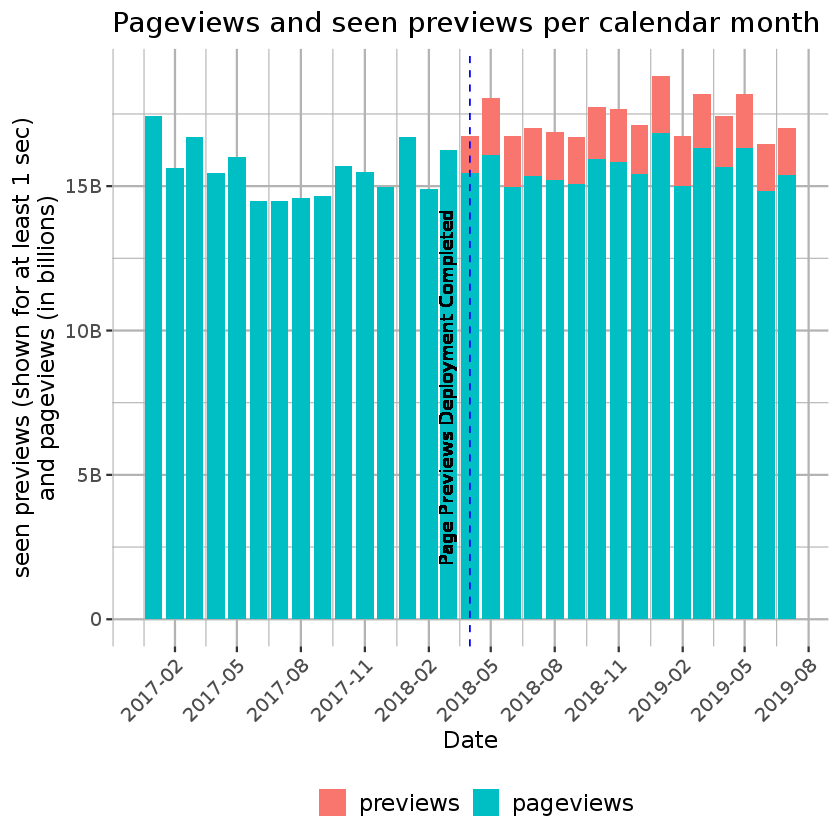

In [107]:
# Create stacked bar charts of page interactions
p <- ggplot(interactions, aes(x=date, y = monthly_views, fill = forcats::fct_rev(type))) +  
  geom_col() +
  scale_y_continuous("seen previews (shown for at least 1 sec)\nand pageviews (in billions)",labels = polloi::compress) +
  scale_x_date("Date", labels = date_format("%Y-%m"), date_breaks = "3 months") +
  geom_vline(xintercept = as.numeric(as.Date("2018-04-01")),
             linetype = "dashed", color = "blue") +
  geom_text(aes(x=as.Date('2018-04-01'), y=8E9, label="Page Previews Deployment Completed"), size=4, vjust = -1.2, angle = 90, color = "black") +
  labs(title = "Pageviews and seen previews per calendar month") +
  ggthemes::theme_tufte(base_size = 14, base_family = "Gill Sans") +
  theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"),
        legend.position="bottom",
        legend.title=element_blank(),
        legend.text=element_text(size=14))

ggsave(filename="Pageviews and interactions_StackedBar.png", plot = p, path = 'Figures', units = "in", dpi = 192, height = 6, width = 10, limitsize = FALSE)  
p

In [108]:
# Calculate total monthly interactions (sum of pageviews and previews) on desktop
interactions_total <- interactions %>%
  filter(date >= "2018-04-01") %>% #filter to first month previews rolled out.
  group_by(date) %>%
  summarise(interactions = sum(monthly_views)) %>%
  arrange(date) %>%
  mutate(yoy_percent = ((interactions/lag(interactions,12) -1)*100))

knitr::kable(interactions_total)



|date       | interactions| yoy_percent|
|:----------|------------:|-----------:|
|2018-04-01 |  16736272662|          NA|
|2018-05-01 |  18047017946|          NA|
|2018-06-01 |  16751441350|          NA|
|2018-07-01 |  17019003787|          NA|
|2018-08-01 |  16867847479|          NA|
|2018-09-01 |  16713641739|          NA|
|2018-10-01 |  17755511665|          NA|
|2018-11-01 |  17657210758|          NA|
|2018-12-01 |  17102978197|          NA|
|2019-01-01 |  18813460266|          NA|
|2019-02-01 |  16733002993|          NA|
|2019-03-01 |  18190360901|          NA|
|2019-04-01 |  17420271488|   4.0869245|
|2019-05-01 |  18179307830|   0.7330290|
|2019-06-01 |  16449779883|  -1.8008090|
|2019-07-01 |  17021113541|   0.0123965|